In [9]:
del model
import gc
gc.collect()

34031

In [3]:
# -*- coding: utf-8 -*-


#==============================================================================
# # # Module
#==============================================================================

from __future__ import print_function


import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import subprocess
import os
import pickle
import sklearn 

from sklearn.model_selection import train_test_split

from xgboost.sklearn import XGBClassifier




import keras.backend as K

from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121, DenseNet169,DenseNet201, preprocess_input
#from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.nasnet import NASNetMobile,NASNetLarge

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,  img_to_array, load_img



from keras.applications.xception import Xception, preprocess_input

from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Input, Conv2D, MaxPooling2D, merge, Lambda,UpSampling2D, concatenate, \
Reshape, Dropout,Cropping2D,Activation, BatchNormalization
from keras.models import Model, load_model
import pandas as pd

from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.callbacks import Callback

from keras.optimizers import Adam

from sklearn.metrics import accuracy_score
from keras import regularizers
#from dummyPy import OneHotEncoder
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

import itertools
import time

import gc




#os.chdir(r'.....\SDP_code\resnet') ##
#os.chdir(r'resnet') ##
import resnet
from resnet import basic_block

#==============================================================================
# # # Initial setting
#==============================================================================

Using TensorFlow backend.


In [4]:

train_read_path = r'./dataset3/train/' ##
val_read_path = r'./dataset3/validation/' ##

h_size,w_size= 224,224
size, channel = (224,224), 3

num_classes = 2
block_par = [3, 4, 6, 3]

batch = 32


save_dir =  './np_data_model/'
save_file = 'DenseNet121_remodel_layer_51_with_dropout_verification_try_try_08'


In [5]:

#==============================================================================
# # # Train - Generator
#==============================================================================
'''
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=[0.9, 1.1], 
        fill_mode = 'reflect')
'''

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
    directory=train_read_path,
    target_size=(h_size,w_size),
    color_mode="rgb",
    batch_size=batch,
    class_mode="binary",
    shuffle=True,
    seed=42
)


valid_datagen = ImageDataGenerator(
        rescale=1./255)



valid_generator = valid_datagen.flow_from_directory(
    directory=val_read_path,
    target_size=(h_size,w_size),
    color_mode="rgb",
    batch_size=65,
    class_mode="binary",
    shuffle=False,
    seed=42
)


Found 2667 images belonging to 2 classes.
Found 1152 images belonging to 2 classes.


In [13]:


def build_model_2():
    inputs = Input(shape=(h_size,w_size,3))
    #inputs = Lambda(lambda x: x/275. - 1.0)(inputs)
    # create the base pre-trained model
    #base_model = load_model(save_dir+'Stage_1_DenseNet169_binary_crossentropy_final_1.h5')
    base_model = load_model('best_model/use_for_train/'+'Stage_1_DenseNet121_recover_with_dropout_binary_acc.h5')

    #base_model =DenseNet121(weights=None,input_tensor=inputs,  include_top=True)

    x = base_model.layers[51].output
    print ('shape is = ', x.get_shape())
    
    x= GlobalAveragePooling2D()(x)
    print ('shape is = ', x.get_shape())

    
    #x = Dense(128,activation='relu')(x)
    
    x= BatchNormalization()(x)
    x= Activation('relu')(x)
    '''
    x = Dropout(0.3)(x)
    x = Dense(32,activation='relu')(x)
    
    x = Dense(32,activation='linear', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
    x= BatchNormalization()(x)
    x= Activation('relu')(x)
    '''
    
    x = Dropout(0.8)(x)   #BN with dropout ?? try .
    
    output = Dense(1,activation = 'sigmoid')(x)


    model = Model(inputs=base_model.input, outputs=output)
    model.summary()

    return model

In [14]:

#==============================================================================
# # # Train - Fit - ResNet
#==============================================================================

model = build_model_2()

#model = load_model(save_dir+'Stage_1_DenseNet121_binary_generator_1_acc.h5')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



shape is =  (?, 56, 56, 128)
shape is =  (?, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________

In [15]:
def lr_epoch(epochs):
    learning_rate_ = 0.0102
    decay= 0.01/100.
    lr = learning_rate_ - epochs*decay
    return lr

In [16]:


Step_Train = train_generator.n//train_generator.batch_size

print (train_generator.n, train_generator.batch_size)
Step_Valid = valid_generator.n

#define callback


#define callback
model_save_loss = save_dir+'Stage_1_'+save_file+'_binary_loss.h5'
model_save_acc = save_dir+'Stage_1_'+save_file+'_binary_acc.h5'
checkpoint_loss = ModelCheckpoint(model_save_loss, monitor='val_loss',save_best_only=True, mode='auto')
checkpoint_acc = ModelCheckpoint(model_save_acc, monitor='val_acc',save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_loss',  patience=40,  mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=15, min_lr=0.00001,verbose=1)
#（best val accuarcy saved 
lr_scheduler= LearningRateScheduler(lr_epoch,verbose=1)
#callback_list = [checkpoint_loss,checkpoint_acc, earlystop,lr_scheduler]
callback_list = [checkpoint_loss,checkpoint_acc, earlystop]


# starts trauning 
his = model.fit_generator(generator=train_generator,
                            steps_per_epoch=Step_Train,
                            validation_data=valid_generator,
                            validation_steps=Step_Valid,
                            epochs=150, verbose = 1,
                             callbacks= callback_list)






2667 32
Epoch 1/150
83/83 [==============================] - 66s 796ms/step - loss: 0.7891 - acc: 0.5739 - val_loss: 1.3464 - val_acc: 0.6319
Epoch 3/150
83/83 [==============================] - 67s 805ms/step - loss: 0.6189 - acc: 0.6717 - val_loss: 1.3977 - val_acc: 0.4887
Epoch 4/150
83/83 [==============================] - 65s 785ms/step - loss: 0.5061 - acc: 0.7581 - val_loss: 1.6273 - val_acc: 0.5243
Epoch 5/150
83/83 [==============================] - 63s 761ms/step - loss: 0.4363 - acc: 0.8050 - val_loss: 0.4656 - val_acc: 0.7839
Epoch 6/150
83/83 [==============================] - 64s 770ms/step - loss: 0.4292 - acc: 0.8178 - val_loss: 0.5761 - val_acc: 0.7118
Epoch 7/150
83/83 [==============================] - 62s 749ms/step - loss: 0.4252 - acc: 0.8224 - val_loss: 0.4857 - val_acc: 0.7865
Epoch 8/150
83/83 [==============================] - 62s 749ms/step - loss: 0.3800 - acc: 0.8442 - val_loss: 0.4319 - val_acc: 0.8090
Epoch 9/150
83/83 [==============================] - 6

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



83/83 [==============================] - 60s 718ms/step - loss: 0.2334 - acc: 0.9134 - val_loss: 0.3820 - val_acc: 0.8490
Epoch 64/150
83/83 [==============================] - 62s 751ms/step - loss: 0.1970 - acc: 0.9360 - val_loss: 0.4100 - val_acc: 0.8420
Epoch 65/150
83/83 [==============================] - 60s 728ms/step - loss: 0.2018 - acc: 0.9262 - val_loss: 0.3833 - val_acc: 0.8446
Epoch 66/150
83/83 [==============================] - 59s 712ms/step - loss: 0.2076 - acc: 0.9277 - val_loss: 0.4280 - val_acc: 0.8290


In [ ]:


callback_list_2 = [checkpoint_loss,checkpoint_acc, earlystop,reduce_lr]



# starts trauning 
his_2 = model.fit_generator(generator=train_generator,
                            steps_per_epoch=Step_Train,
                            validation_data=valid_generator,
                            validation_steps=Step_Valid,
                            epochs=300, verbose = 1,
                             callbacks= callback_list_2)


Epoch 1/300
83/83 [==============================] - 67s 801ms/step - loss: 0.1985 - acc: 0.9288 - val_loss: 1.0672 - val_acc: 0.7031
Epoch 2/300
83/83 [==============================] - 65s 784ms/step - loss: 0.1876 - acc: 0.9308 - val_loss: 0.4943 - val_acc: 0.8273
Epoch 3/300
83/83 [==============================] - 65s 784ms/step - loss: 0.2056 - acc: 0.9303 - val_loss: 0.4993 - val_acc: 0.8273
Epoch 4/300
83/83 [==============================] - 65s 778ms/step - loss: 0.2560 - acc: 0.9158 - val_loss: 0.5949 - val_acc: 0.7622
Epoch 5/300
83/83 [==============================] - 64s 777ms/step - loss: 0.2437 - acc: 0.9142 - val_loss: 0.3572 - val_acc: 0.8637
Epoch 6/300
83/83 [==============================] - 64s 769ms/step - loss: 0.1805 - acc: 0.9360 - val_loss: 0.4030 - val_acc: 0.8472
Epoch 7/300
83/83 [==============================] - 64s 771ms/step - loss: 0.1897 - acc: 0.9405 - val_loss: 0.3508 - val_acc: 0.8655
Epoch 8/300
83/83 [==============================] - 63s 764ms

In [2]:
h1 = his.history
h2 = his_2.history
h = {}
for k in h1: h[k] = np.hstack([h1[k], h2[k]])

NameError: name 'his' is not defined

In [ ]:
def display_history(history):
    # list all data in history
    print(history.keys())
    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(save_dir+'Stage_1_'+save_file+'_binary_acc.png')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(save_dir+'Stage_1_'+save_file+'_binary_loss.png')
    plt.show()
display_history(h)

In [12]:
model.save(save_dir+'Stage_1_'+save_file+'_binary_final.h5')

In [ ]:
model.evaluate_generator(valid_generator,verbose=1)

In [7]:
model_save_acc = save_dir+'Stage_1_'+save_file+'_binary_acc.h5'

In [8]:
model = load_model(model_save_acc)

In [9]:
model.evaluate_generator(valid_generator,verbose=1)

18/18 [==============================] - 19s 1s/step


[0.3569327948951266, 0.8810763962359892]

In [46]:
for i, layer in enumerate(model.layers):
    print ('{}layer, name is {}'.format(i,layer.name))

0layer, name is input_2
1layer, name is zero_padding2d_3
2layer, name is conv1/conv
3layer, name is conv1/bn
4layer, name is conv1/relu
5layer, name is zero_padding2d_4
6layer, name is pool1
7layer, name is conv2_block1_0_bn
8layer, name is conv2_block1_0_relu
9layer, name is conv2_block1_1_conv
10layer, name is conv2_block1_1_bn
11layer, name is conv2_block1_1_relu
12layer, name is conv2_block1_2_conv
13layer, name is conv2_block1_concat
14layer, name is conv2_block2_0_bn
15layer, name is conv2_block2_0_relu
16layer, name is conv2_block2_1_conv
17layer, name is conv2_block2_1_bn
18layer, name is conv2_block2_1_relu
19layer, name is conv2_block2_2_conv
20layer, name is conv2_block2_concat
21layer, name is conv2_block3_0_bn
22layer, name is conv2_block3_0_relu
23layer, name is conv2_block3_1_conv
24layer, name is conv2_block3_1_bn
25layer, name is conv2_block3_1_relu
26layer, name is conv2_block3_2_conv
27layer, name is conv2_block3_concat
28layer, name is conv2_block4_0_bn
29layer, nam

In [60]:

'''
valid_generator = valid_datagen.flow_from_directory(
    directory=val_read_path,
    target_size=size,
    color_mode="rgb",
    batch_size=65,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
'''

check_generator = valid_datagen.flow_from_directory(
    directory=val_read_path,
    target_size=(size, size),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 1878 images belonging to 2 classes.


In [68]:
pred = model.predict_generator(valid_generator, verbose=1)
print (pred.shape)
labels = valid_generator.classes 
labels = np.array(labels)
print (labels.shape)
pred=np.argmax(pred,axis=1)



29/29 [==============================] - 29s 1s/step
(1878, 2)
(1878,)


In [69]:
print (pred[:20])
print (labels[:20])

[1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [52]:
valid_generator.class_indices

{'NG': 0, 'OK': 1}

In [71]:
import pandas as pd
pred_dict = {'pred':pred}
pred_df = pd.DataFrame(pred_dict)
pred_df['pred'].value_counts()

1    1070
0     808
Name: pred, dtype: int64

In [8]:
# gc.collect()

568

In [116]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    normalize=True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() +cm.min())/ 2.
    print (thresh)
    #thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [117]:
class_names = ['NG','OK']

[[410 527]
 [398 543]]
Normalized confusion matrix
0.5


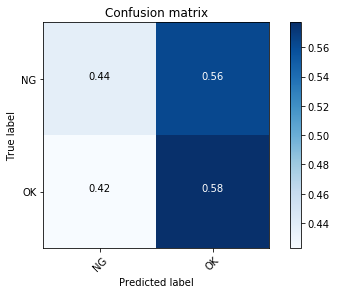

In [118]:
cnf_matrix = confusion_matrix(labels, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')


In [119]:
from sklearn import metrics
print (metrics.classification_report(labels, pred))

             precision    recall  f1-score   support

          0       0.51      0.44      0.47       937
          1       0.51      0.58      0.54       941

avg / total       0.51      0.51      0.51      1878



In [121]:
import json
with open(save_dir+'history_DenseNet121.json', 'w') as f:
    json.dump(his.history, f)



In [18]:
with open (save_dir+'history_DEnseNet121.json','r') as f:
    his = json.load(f)

dict_keys(['val_acc', 'val_loss', 'acc', 'loss'])


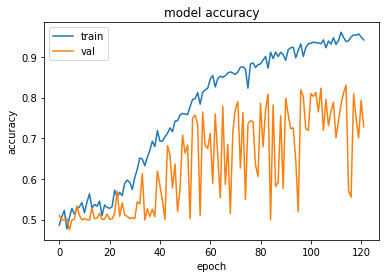

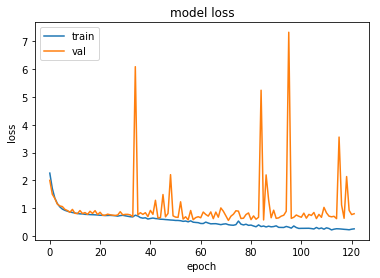

In [22]:
def display_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
display_history(his)

In [ ]:
def display_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('accuracy_2.png')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('loss_2.png')
    plt.show()
display_history(his)